# Training GATAE

This notebook shows how to train the anomaly detection model.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import optuna

from models import RelationalSTAE, GATAE
from parameters import GATAEParameters, TrainingParameters
from datautils import get_morning_data, get_rstae_sequence
from training import save_model, load_model, train_gatae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [3]:
training_params = TrainingParameters(
    learning_rate=1e-4,
    batch_size=1,
    timesteps=2,
    n_epochs=3
)

In [4]:
training_data = get_rstae_sequence(1, timesteps=training_params.timesteps) # train on day 1, free of crashes

In [5]:
hyperparams = GATAEParameters(
    num_features=training_data[0][0].num_features,
    latent_dim=32,
    gcn_hidden_dim=64,
    dropout=0.2,
    num_layers=3,
    num_heads=2
)

In [6]:
ae = GATAE(hyperparams)

In [7]:
ae(training_data[0][0]).shape

torch.Size([196, 3])

In [8]:
shapes = [data[1].x.shape for data in training_data]
for shape in shapes:
    if not shape == torch.Size([196, 3]):
        print("Error")

In [9]:
shapes = [data[0].x.shape for data in training_data]
for i, shape in enumerate(shapes):
    if not shape == torch.Size([1960, 3]):
        print("Error", i, len(shapes), shape)

Error 0 1438 torch.Size([392, 3])
Error 1 1438 torch.Size([392, 3])
Error 2 1438 torch.Size([392, 3])
Error 3 1438 torch.Size([392, 3])
Error 4 1438 torch.Size([392, 3])
Error 5 1438 torch.Size([392, 3])
Error 6 1438 torch.Size([392, 3])
Error 7 1438 torch.Size([392, 3])
Error 8 1438 torch.Size([392, 3])
Error 9 1438 torch.Size([392, 3])
Error 10 1438 torch.Size([392, 3])
Error 11 1438 torch.Size([392, 3])
Error 12 1438 torch.Size([392, 3])
Error 13 1438 torch.Size([392, 3])
Error 14 1438 torch.Size([392, 3])
Error 15 1438 torch.Size([392, 3])
Error 16 1438 torch.Size([392, 3])
Error 17 1438 torch.Size([392, 3])
Error 18 1438 torch.Size([392, 3])
Error 19 1438 torch.Size([392, 3])
Error 20 1438 torch.Size([392, 3])
Error 21 1438 torch.Size([392, 3])
Error 22 1438 torch.Size([392, 3])
Error 23 1438 torch.Size([392, 3])
Error 24 1438 torch.Size([392, 3])
Error 25 1438 torch.Size([392, 3])
Error 26 1438 torch.Size([392, 3])
Error 27 1438 torch.Size([392, 3])
Error 28 1438 torch.Size([392,

In [10]:
ae, losses = train_gatae(gataeparams=hyperparams, trainingparams=training_params, training_data=training_data, mse_weights=mse_weights, verbose=True)

 33%|███▎      | 1/3 [00:24<00:49, 24.72s/it]

Epoch number 0 last 100 loss 0.00885969145456329


 67%|██████▋   | 2/3 [00:49<00:24, 24.52s/it]

Epoch number 1 last 100 loss 0.009083488603355363


100%|██████████| 3/3 [01:13<00:00, 24.41s/it]

Epoch number 2 last 100 loss 0.009138724211370573


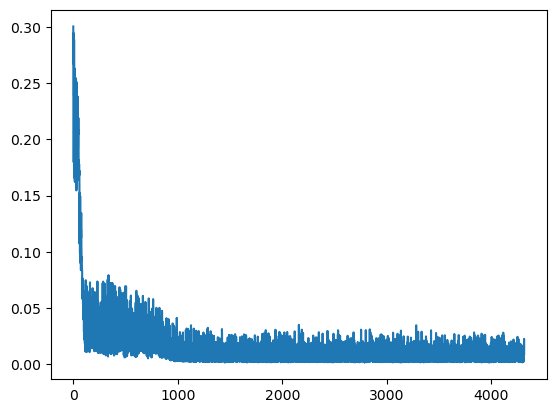

In [11]:
plt.plot(losses)

In [12]:
thresh = compute_anomaly_threshold_rstae(training_data, ae, mse_weights, 'max')

100%|██████████| 1438/1438 [00:07<00:00, 180.73it/s]


In [13]:
use_pretrained = False
if not use_pretrained:
    test_data = get_rstae_sequence(4, timesteps=training_params.timesteps)

In [14]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [15]:
np.mean(test_errors)

0.013268477

In [16]:
anomalies = threshold_anomalies(thresh, test_errors)

In [18]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [19]:
df.to_csv('./saved_results/day4_results_test_rstae.csv')

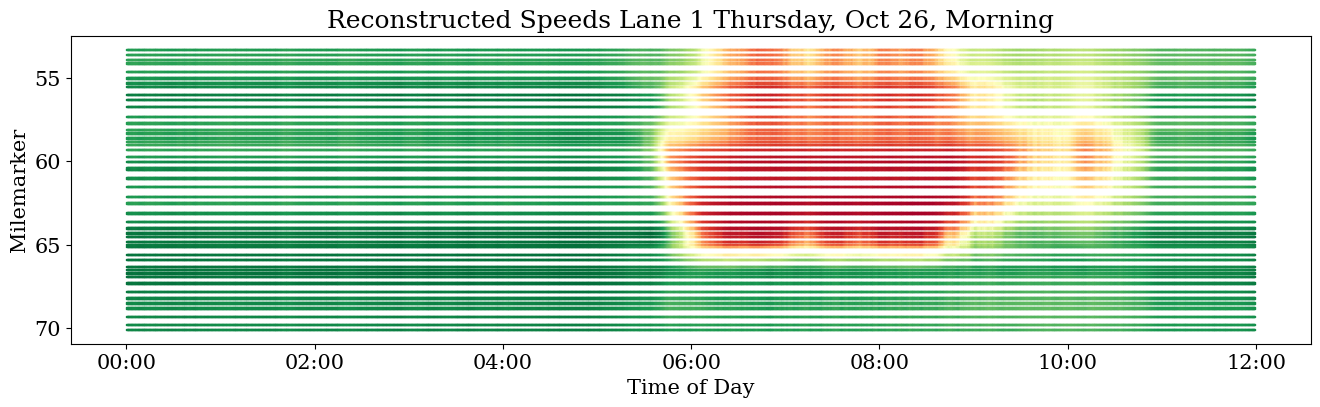

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/day4_results_test_rstae.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed']),marker='s',s=1, cmap='viridis')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

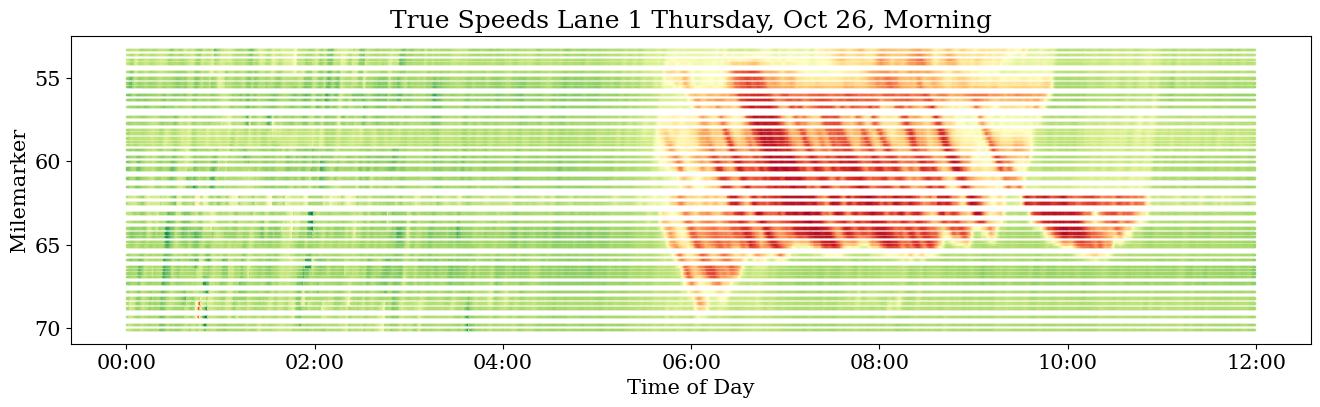

In [21]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

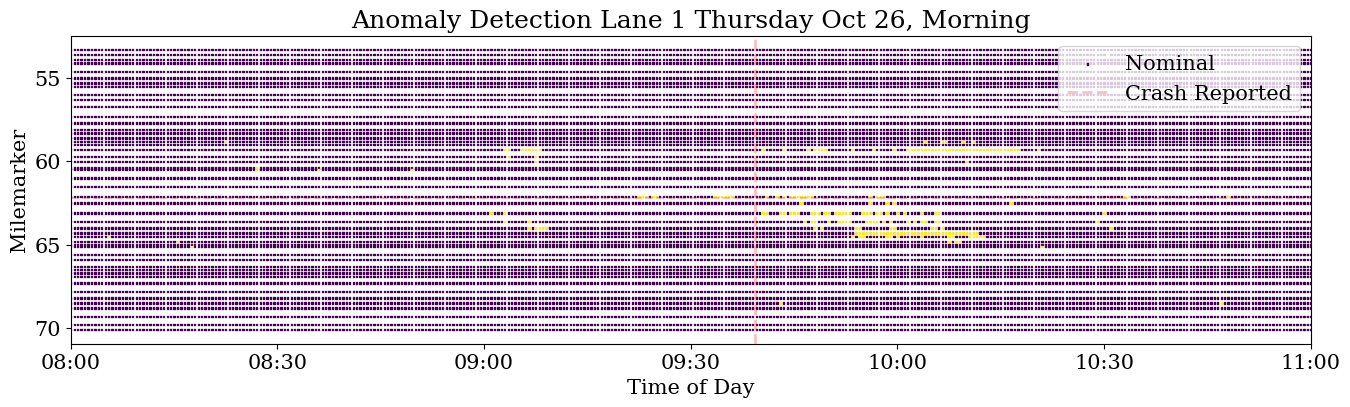

In [22]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()